In [1]:
import os
import sys
sys.path.append('..')

In [2]:
import import_ipynb
from utils.dataset_loader import CreatePadDataset
from utils.training import PadLearning

importing Jupyter notebook from ..\utils\dataset_loader.ipynb
importing Jupyter notebook from ..\utils\training.ipynb


In [147]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import random
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:
### cpu, gpu 선택
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 불용어 사용 여부
use_stopword = True

### batch_size
batch_size = 32

In [5]:
### 미리 만들어둔 데이터셋을 가져옴
dataset = CreatePadDataset(device=device, use_stopword=use_stopword)

### 데이터셋에서 iterator만 뽑아냄
train_iterator, valid_iterator, test_iterator = dataset.get_iterator(batch_size=batch_size)

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, dec_hid_dim, num_layers=n_layers, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        
    def forward(self, src, src_len):
        # src = [batch_size, src_len]
        # src_len = [batch_size]
        
        embedded = self.dropout(self.embedding(src))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
        
        packed_outputs, hidden = self.rnn(packed_embedded)
        # outputs = [src_len, batch_size, enc_hid_dim*num_layers]
        # hidden = [num_layers*directional, batch_size, enc_hid_dim]
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        hidden = self.fc(torch.cat((hidden[-2], hidden[-1]), dim=1))
        # hidden = [batch_size, dec_hid_dim]
        
        return outputs, hidden

In [7]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.energy = nn.Linear(enc_hid_dim*2+dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)
        
    def forward(self, encoder_outputs, hidden):
        # encoder_outputs = [src_len, batch_size, enc_hid_dim*2]
        # hidden = [batch_size, dec_hid_dim]
        
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # hidden = [batch_size, src_len, dec_hid_dim]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch_size, src_len, enc_hid_dim*2]
        
        energy = torch.tanh(self.energy(torch.cat((encoder_outputs, hidden), dim=2)))
        # energy = [batch_size, src_len, dec_hid_dim]
        
        v = self.v(energy).squeeze(2)
        # v = [batch_size, src_len]
        
        return F.softmax(v, dim=1)

In [46]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim+enc_hid_dim*2, dec_hid_dim, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(dec_hid_dim+enc_hid_dim*2+emb_dim, output_dim)
        
    def forward(self, x, encoder_outputs, hidden):
        # x = [batch_size]
        # encoder_outputs = [src_len, batch_size, enc_hid_dim*2]
        # hidden = [batch_size, dec_hid_dim]
        
        x = x.unsqueeze(0)
        # x = [1, batch_size]
        
        embedded = self.dropout(self.embedding(x))
        
        a = self.attention(encoder_outputs, hidden)
        # a = [batch_size, src_len]
        
        a = a.unsqueeze(1)
        # a = [batch_size, 1, src_len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch_size, src_len, enc_hid_dim*2]
        
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch_size, 1, enc_hid_dim*2]
        
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch_size, enc_hid_dim*2]
        
        
        rnn_output, hidden = self.rnn(torch.cat((embedded, weighted), dim=2), hidden.unsqueeze(0))
        # rnn_output = [1, batch_size, hid_dim]
        # hidden = [1, bach_size, hid_dim]
        
        
        outputs = self.fc_out(torch.cat((rnn_output.squeeze(0), weighted.squeeze(0), embedded.squeeze(0)), dim=1))
        
        return outputs, hidden.squeeze(0), a.squeeze(1)

In [47]:
class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, device):
        super().__init__()
        self.enc = enc
        self.dec = dec
        self.device = device
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        # src = [src_len, batch_size]
        # src_len = [batch_size]
        # trg = [trg_len, batch_size]
        
        encoder_outputs, hidden = self.enc(src, src_len)
        # encoder_outputs = [src_len, batch_size, enc_hid_dim*2]
        # hidden = [batch_size, dec_hid_dim]
        
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        output_dim = self.dec.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, output_dim).to(self.device)
        
        rnn_input = trg[0]
        
        for t in range(1, trg_len):
            output, hidden, _ = self.dec(rnn_input, encoder_outputs, hidden)
            # output = [batch_size, output_dim]
            # hidden = [batch_size, dec_hid_dim]
            
            outputs[t] = output
            
            top1 = torch.argmax(output, dim=1)
            
            rnn_input = top1 if random.random() > teacher_forcing_ratio else trg[t]
            
        return outputs

In [48]:
input_dim = len(dataset.SRC.vocab)
output_dim = len(dataset.TRG.vocab)
emb_dim = 256
enc_hid_dim = 512
dec_hid_dim = 512
n_layers = 1
dropout = 0.1
clip = 1

In [49]:
enc = Encoder(input_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout).to(device)
att = Attention(enc_hid_dim, dec_hid_dim)
dec = Decoder(output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout, att).to(device)

model = Seq2Seq(enc, dec, device).to(device)
epochs = 10

In [50]:
pad_index = dataset.TRG.vocab.stoi[dataset.TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index=pad_index)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [51]:
model

Seq2Seq(
  (enc): Encoder(
    (embedding): Embedding(7854, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (dec): Decoder(
    (attention): Attention(
      (energy): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (dropout): Dropout(p=0.1, inplace=False)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
  )
)

In [52]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,661 trainable parameters


In [53]:
learn = PadLearning()

for epoch in range(epochs):
    model, train_loss = learn.train(model, criterion, optimizer, train_iterator, clip)
    eval_loss = learn.evaluation(model, criterion, valid_iterator)
    print(train_loss, eval_loss)

  0%|                                                                                  | 1/907 [00:00<01:44,  8.70it/s]

4.553760657368316 4.071242108941078


  0%|▏                                                                                 | 2/907 [00:00<01:17, 11.63it/s]

3.504850078443971 3.61831134557724


  0%|                                                                                  | 1/907 [00:00<02:10,  6.94it/s]

3.0423539144858767 3.4136534333229065


  0%|                                                                                  | 1/907 [00:00<01:40,  9.01it/s]

2.759952999528214 3.270451746881008


  0%|                                                                                  | 1/907 [00:00<02:01,  7.46it/s]

2.5282196131141603 3.2687829732894897


  0%|                                                                                  | 1/907 [00:00<01:36,  9.35it/s]

2.3550154747484537 3.2101026698946953


  0%|                                                                                  | 1/907 [00:00<01:32,  9.80it/s]

2.213585009911357 3.1599020287394524


  0%|▏                                                                                 | 2/907 [00:00<01:13, 12.35it/s]

2.0657895380238847 3.153931610286236


  0%|                                                                                  | 1/907 [00:00<02:05,  7.25it/s]

1.9577696464027565 3.1783174723386765


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.10it/s]

1.8407444386129999 3.203150160610676


In [111]:
def Inference(src, trg, model, src_vocab, trg_vocab, device):
    model.eval()
    
    src = ['<sos>'] + src + ['<eos>']
    trg=  ['<sos>'] + trg + ['<eos>']
    
    src_input = torch.LongTensor([src_vocab[x] for x in src]).unsqueeze(1).to(device)
    src_len_input = torch.LongTensor([len(src)])
    trg_input = torch.LongTensor([trg_vocab['<sos>']]).to(device)

    src_len = len(src)
    result = [trg_input.item()]
    attention = []
    
    with torch.no_grad():
        encoder_outputs, hidden = model.enc(src_input, src_len_input)
        
        while True:
            output, hidden, a = model.dec(trg_input, encoder_outputs, hidden)
            attention.append(a.squeeze(0).cpu().detach().numpy())
            trg_input = torch.argmax(output, dim=1)
            result += [trg_input.item()]
            
            if trg_input.item() == trg_vocab['<eos>']:
                break
        
    return result, attention

In [174]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = ['<sos>'] + sentence + ['<eos>']
    y_ticks = translation + ['<eos>']
    
    
    print(len(x_ticks))
    print(len(y_ticks))
    print(np.array(attention).shape)
    
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    plt.close()

15
14
(12, 15)


c:\users\uclab\anaconda3\envs\learning\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\users\uclab\anaconda3\envs\learning\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


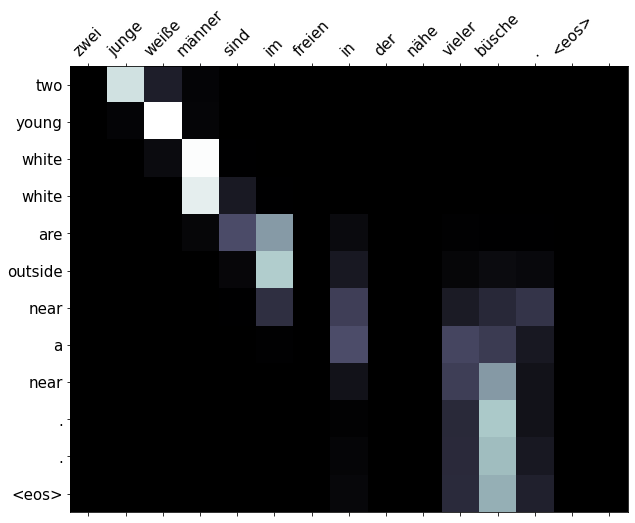

10
14
(12, 10)


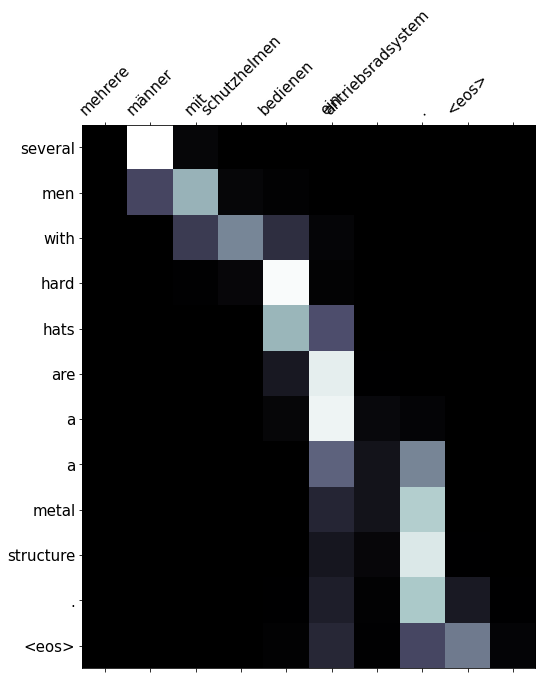

In [175]:
count = 0
for data in dataset.train_data:
    src = data.src
    trg = data.trg
    result, attention = Inference(src, trg, model, dataset.SRC.vocab.stoi, dataset.TRG.vocab.stoi, device)

    result2word = [dataset.TRG.vocab.itos[x] for x in result]
    
    target = ' '.join(trg)
    prediction = ' '.join(result2word[1:-1])
    display_attention(src, result2word, attention)
    count += 1
    if count == 2:
        break


defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x000001F84FBB35C8>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             '.': 4,
             'ein': 5,
             'einem': 6,
             'in': 7,
             'eine': 8,
             ',': 9,
             'und': 10,
             'mit': 11,
             'auf': 12,
             'mann': 13,
             'einer': 14,
             'der': 15,
             'frau': 16,
             'die': 17,
             'zwei': 18,
             'einen': 19,
             'im': 20,
             'an': 21,
             'von': 22,
             'sich': 23,
             'dem': 24,
             'mädchen': 25,
             'junge': 26,
             'vor': 27,
             'zu': 28,
             'steht': 29,
             'männer': 30,
             'sitzt': 31,
             'hund': 32,
             'den': 33,
             'straße': 34,
             'während': 35,
     